<a href="https://colab.research.google.com/github/Mpriynka/LTH-on-FSL/blob/main/LTH_ON_FSL_TRIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch                                            # Main PyTorch library — tensors, computations, GPU support
import torch.nn as nn                                   # Tools to create neural network layers like Conv, Linear
import torch.optim as optim                             # Optimization algorithms like SGD, Adam
from torch.utils.data import DataLoader, random_split   # Helps load data in batches while training; Splits dataset into training & validation parts
from torchvision import datasets, transforms            # Built-in datasets like CIFAR; Apply preprocessing like Resize, Normalize, Flip
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm                                   # Progress bar while training
import random
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class CIFAR10EpisodicDataset:
    def __init__(self, dataset, n_way=5, k_shot=1, n_query=15, num_episodes=100):
        self.dataset = dataset
        self.n_way = n_way
        self.k_shot = k_shot
        self.n_query = n_query
        self.num_episodes = num_episodes

        # Group data by class
        self.class_dict = {}
        for idx, (image, label) in enumerate(dataset):
            if label not in self.class_dict:
                self.class_dict[label] = []
            self.class_dict[label].append(image)

        print(f"Created dataset with {len(self.class_dict)} classes")
        for class_id, images in self.class_dict.items():
            print(f"Class {class_id}: {len(images)} images")

    def __len__(self):
        return self.num_episodes

    def __getitem__(self, episode_idx):
        # Randomly select N classes
        selected_classes = random.sample(list(self.class_dict.keys()), self.n_way)

        support_images = []
        support_labels = []
        query_images = []
        query_labels = []

        for class_idx, class_id in enumerate(selected_classes):
            class_images = self.class_dict[class_id]
            # Randomly select K support + N query images
            selected_images = random.sample(class_images, self.k_shot + self.n_query)

            # Add to support set
            support_images.extend(selected_images[:self.k_shot])
            support_labels.extend([class_idx] * self.k_shot)

            # Add to query set
            query_images.extend(selected_images[self.k_shot:self.k_shot + self.n_query])
            query_labels.extend([class_idx] * self.n_query)

        # Convert to tensors
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels)
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels)

        return support_images, support_labels, query_images, query_labels

class EpisodicDataLoader:
    def __init__(self, dataset, n_way=5, k_shot=1, n_query=15, num_episodes=100):
        self.dataset = CIFAR10EpisodicDataset(dataset, n_way, k_shot, n_query, num_episodes)
        self.num_episodes = num_episodes

    def __len__(self):
        return self.num_episodes

    def __iter__(self):
        for i in range(self.num_episodes):
            yield self.dataset[i]

In [ ]:
'''
Prototype = mean of features from support images of a class.
for each query image:
→ Calculate distance from each prototype
→ Nearest prototype
→ Predicted class
'''
# Feature extractor (encoder)
class Conv4ProtoNet(nn.Module):
    def __init__(self, in_channels=3, hidden_size=64):
        # super(Conv4ProtoNet, self).__init__()
        super().__init__()
        self.encoder = nn.Sequential(
            # Layer 1 - Input: 32x32 -> Output: 16x16
            nn.Conv2d(in_channels, hidden_size, 3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Layer 2 - Input: 16x16 -> Output: 8x8
            nn.Conv2d(hidden_size, hidden_size, 3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Layer 3 - Input: 8x8 -> Output: 4x4
            nn.Conv2d(hidden_size, hidden_size, 3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Layer 4 - Input: 4x4 -> Output: 2x2
            nn.Conv2d(hidden_size, hidden_size, 3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Global average pooling to get consistent output size
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

# uses the encoder to compute prototypes and classify queries.
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        # super(ProtoNet, self).__init__()
        super().__init__()
        self.encoder = encoder

    def compute_prototypes(self, support_images, support_labels):
        # Extract features
        features = self.encoder(support_images)

        # Get unique classes
        classes = torch.unique(support_labels)
        prototypes = []

        for class_id in classes:
            # Find all examples of this class
            mask = support_labels == class_id
            class_features = features[mask]
            # Compute prototype as mean of examples
            prototypes.append(class_features.mean(0))

        return torch.stack(prototypes), classes

    def forward(self, support_images, support_labels, query_images):
        prototypes, classes = self.compute_prototypes(support_images, support_labels)
        query_features = self.encoder(query_images)

        # Compute Euclidean distances between queries and prototypes
        # Expand dimensions for broadcasting: query_features [N_q, D], prototypes [N_c, D]
        query_features = query_features.unsqueeze(1)  # [N_q, 1, D]
        prototypes = prototypes.unsqueeze(0)          # [1, N_c, D]

        distances = torch.sum((query_features - prototypes) ** 2, dim=2)  # [N_q, N_c]

        # Convert distances to probabilities
        log_probabilities = nn.functional.log_softmax(-distances, dim=1)

        return log_probabilities, classes

Starting FIXED training...


100%|██████████| 170M/170M [00:05<00:00, 31.5MB/s]


Creating episodic dataloaders...
Created dataset with 10 classes
Class 6: 5000 images
Class 9: 5000 images
Class 4: 5000 images
Class 1: 5000 images
Class 2: 5000 images
Class 7: 5000 images
Class 8: 5000 images
Class 3: 5000 images
Class 5: 5000 images
Class 0: 5000 images
Saving initial weights...
Initial weights saved!
Starting training...
Epoch 1, Episode 0, Loss: 6.3280, Acc: 0.2267
Epoch 1, Episode 100, Loss: 1.4765, Acc: 0.3467
Epoch 1, Episode 200, Loss: 1.1542, Acc: 0.4267
Epoch 1, Episode 300, Loss: 1.5548, Acc: 0.3467
Epoch 1, Episode 400, Loss: 1.3377, Acc: 0.4000
Epoch 1, Episode 500, Loss: 1.2044, Acc: 0.5067
Epoch 1, Episode 600, Loss: 1.5872, Acc: 0.3067
Epoch 1, Episode 700, Loss: 1.3118, Acc: 0.3200
Epoch 1, Episode 800, Loss: 1.1484, Acc: 0.3867
Epoch 1, Episode 900, Loss: 0.9697, Acc: 0.5333
Epoch 1, Episode 1000, Loss: 1.4312, Acc: 0.3733
Epoch 1, Episode 1100, Loss: 1.1884, Acc: 0.6667
Epoch 1, Episode 1200, Loss: 1.1797, Acc: 0.5733
Epoch 1, Episode 1300, Loss: 1

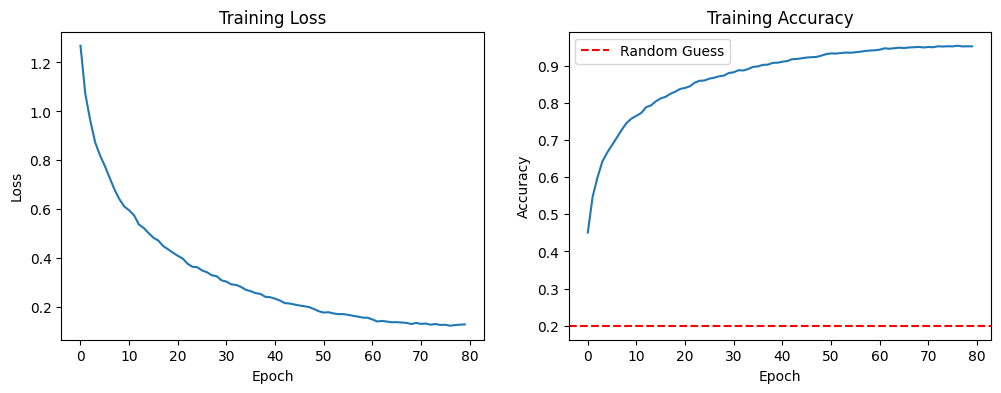

In [ ]:
# Training Function
def train_model_fixed():
    num_ways = 5
    num_shots = 1
    num_queries = 15
    num_episodes = 3000
    num_epochs = 80
    learning_rate = 0.001

    # Data transformations
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Download CIFAR-10
    print("Downloading CIFAR-10 training set...")
    full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Create episodic dataloaders
    print("Creating episodic dataloaders...")
    train_loader = EpisodicDataLoader(full_dataset, n_way=num_ways, k_shot=num_shots,
                                    n_query=num_queries, num_episodes=num_episodes)

    # Initialize model
    model = ProtoNet(Conv4ProtoNet()).to(device)

    # CHANGED: Use AdamW with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # ADDED: Learning rate scheduler (adjusted T_max)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * num_episodes) # Adjust T_max to total number of steps

    # ADDED: Gradient clipping to prevent explosion
    max_grad_norm = 1.0

    # Save initial weights
    print("Saving initial weights...")
    initial_weights = {}
    for name, param in model.named_parameters():
        initial_weights[name] = param.data.clone()
    torch.save(initial_weights, 'initial_weights.pth')
    print("Initial weights saved!")

    # Training loop
    print("Starting training...")
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        num_batches = 0

        for episode_idx, (support_images, support_labels, query_images, query_labels) in enumerate(train_loader):
            support_images = support_images.to(device)
            support_labels = support_labels.to(device)
            query_images = query_images.to(device)
            query_labels = query_labels.to(device)

            # Forward pass
            log_probabilities, classes = model(support_images, support_labels, query_images)

            # Compute loss
            loss = nn.functional.nll_loss(log_probabilities, query_labels)

            # Backward pass with gradient clipping
            optimizer.zero_grad()
            loss.backward()

            # ADDED: Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            epoch_loss += loss.item()

            # Compute accuracy
            predictions = torch.argmax(log_probabilities, dim=1)
            accuracy = (predictions == query_labels).float().mean()
            epoch_acc += accuracy.item()
            num_batches += 1

            if episode_idx % 100 == 0: # Print less frequently
                print(f'Epoch {epoch+1}, Episode {episode_idx}, Loss: {loss.item():.4f}, Acc: {accuracy.item():.4f}')

            # Update learning rate per step
            scheduler.step()


        avg_loss = epoch_loss / num_batches
        avg_acc = epoch_acc / num_batches
        train_losses.append(avg_loss)
        train_accuracies.append(avg_acc)

        current_lr = scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else learning_rate # Handle older schedulers
        print(f'🎯 Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}, LR: {current_lr:.6f}')


    # Save final model
    torch.save(model.state_dict(), 'dense_model.pth')
    print("Dense training completed!")

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Random Guess')
    plt.legend()
    plt.show()

    return model, initial_weights

# Start training with fixed version
print("Starting FIXED training...")
model, initial_weights = train_model_fixed()